In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
#import ternary
from sklearn import preprocessing

from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import FunctionTransformer
from matplotlib.colors import LinearSegmentedColormap
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import pdist, squareform
from geopandas import GeoDataFrame
from shapely.geometry import Point
sns.set()

In [10]:
def flatten(container):
    "Flattens lists"
    for i in container:
        if isinstance(i, (list, tuple)):
            for j in flatten(i):
                yield j
        else:
            yield i

def feature_list(no_of_neighbors):
    """
    Creates a list of features given number of adjacent wells
    param no_of_neighbors: number of adjacent wells used in feature engineering
    """
    print("Getting the features")
    initial = ["thickness", "thickness natural log", "thickness power"]
    features = []
    for item in initial:
        features.append(item)
        for i in range(1, no_of_neighbors + 1):
            features.append(item + " neighbor " + str(i))
    features.append(["x location", "y location", "class"])
    return list(flatten(features))

def data_normalization(dataframe):
    """
    Normalizes the generated stratigraphic data
    param dataframe: a pandas dataframe of thicknesses that has been through feature engineering
    param location: a pandas dataframe with locations 
    """
    print("normalizing")
    normalized_df = (dataframe - dataframe.min()) / (dataframe.max() - dataframe.min()).replace(0, 0.00001)
    return normalized_df
    

def adjacent_wells(dataframe, no_of_neighbors):
    """
    Calculates the adjacent wells and builds the initial dataframe
    param dataframe: dataframe output from the missing function
    param no_of_neighbors: number of adjacent wells used in feature engineering
    """
    hood = squareform(pdist(dataframe.iloc[:, -2:]))
    neighbors = []
    for i in enumerate(hood.argsort()[0:, 1 : no_of_neighbors + 1]):
        selected = (
            dataframe.iloc[hood.argsort()[i[0], 1 : no_of_neighbors + 1], 0:-2]
            .stack()
            .to_frame()
            .T
        )
        selected.columns = selected.columns.droplevel()
        neighbors.append(selected)
    frame = pd.concat(neighbors, sort=False)
    frame.index = range(len(frame))
    neighborhood = pd.concat([dataframe.iloc[:, :-2], frame], axis=1)
    return neighborhood
    
def depth_to_thickness(neighborhood, dataframe):
    """
    Converts the depth dataframe from the adjacent wells function to thicknesses
    param neighborhood: dataframe output from `adjacent_wells`
    param dataframe: dataframe output from function `missing`
    """
    locations = pd.DataFrame()
    df = pd.DataFrame()
    thicknesses = neighborhood.diff(axis=1)*-1
    thicknesses[thicknesses < 0] = 0
    thicknesses.drop(columns=dataframe.columns[0], inplace=True)
    thicknesses[thicknesses < 0] = 0
    thicknesses[thicknesses > 3000] = 0
    locations = pd.concat((locations, dataframe.iloc[:, -2:]))
    df = pd.concat((df, thicknesses))
    return df, locations
  


def build_feature_engineered_dataset(thickness_df, locations_df):
    """
    Takes the generated thickness dataset and runs feature engineering
    param thickness_df: the generated thickness dataset
    param locations_df: the generated locations dataset    
    """
    log_transform = FunctionTransformer(np.log, validate=False)
    power_transform = FunctionTransformer(lambda x: x ** 10, validate=False)
    
    logged = pd.DataFrame(log_transform.transform(thickness_df))
    powered = pd.DataFrame(power_transform.transform(thickness_df)) 
    feature_dataset = (
        pd.concat([thickness_df, logged, powered, locations_df], axis=1)
        .dropna()
        .replace(-np.inf, 0)
    )
    return feature_dataset
  

In [11]:
TRUNCATION_COLOR = "#ffffbf"
ONLAP_COLOR = "#2c7bb6"
HORIZ_COLOR = "#d7191c"
 
truncCmap = LinearSegmentedColormap.from_list("mycmap", ["#ffffff", TRUNCATION_COLOR])
onlapCmap = LinearSegmentedColormap.from_list("mycmap", ["#ffffff", ONLAP_COLOR])
horizCmap = LinearSegmentedColormap.from_list("mycmap", ["#ffffff", HORIZ_COLOR])

In [13]:
dataset = pd.read_csv(r'399neighbors.csv', index_col=[0])
wells_in_vicinity = 10
selected_features = feature_list(wells_in_vicinity)
subset = dataset[selected_features]
le = preprocessing.LabelEncoder()
le_class = le.fit_transform(subset['class'])
subset.loc[:,'le_class'] =  le_class
subset.drop('class', inplace=True, axis=1)

Getting the features


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\strata\lib\site-packages\pandas\core\frame.py:4157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    subset.drop("le_class", axis=1),
    subset["le_class"],
    test_size=0.2,  
    random_state=86,
)

In [15]:
CLF = RandomForestClassifier(
)
CLF.fit(X_train, y_train)
CLF.score(X_test, y_test)

0.9851851851851852

In [16]:
INITIAL = ["thickness", "thickness natural log", "thickness power"]
FEATURES = []
for item in INITIAL:
    FEATURES.append(item)
    for i in range(1, wells_in_vicinity + 1):
        FEATURES.append(item + " neighbor " + str(i))
FEATURES.append(["x location", "y location", "class"])
FLAT_FEATURES = list(flatten(FEATURES))

In [19]:
THICKENED = FLAT_FEATURES[0 : wells_in_vicinity + 1]
THICKENED.append("le_class")
LOGGED = FLAT_FEATURES[wells_in_vicinity + 1 : 2 * wells_in_vicinity + 2]
LOGGED.append("le_class")
POWERED = FLAT_FEATURES[2 * wells_in_vicinity + 2 : 3 * wells_in_vicinity + 3]
POWERED.append("le_class")
LOCATION = ["x location", "y location", "le_class"]
OG_THICKNESS = ["thickness", "le_class"]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    subset.drop(THICKENED, axis=1),
    subset["le_class"],
    test_size=0.2, 
    random_state=86,
)
CLF.fit(X_train, y_train)
THICKNESS_REMOVED = CLF.score(X_test, y_test)
print(f"Without thickness accuracy is {THICKNESS_REMOVED:.3f}")


X_train, X_test, y_train, y_test = train_test_split(
    subset.drop(LOGGED, axis=1),
    subset["le_class"],
    test_size=0.2,  
    random_state=86,
)
CLF.fit(X_train, y_train)
LN_REMOVED = CLF.score(X_test, y_test)
print(f"Without natural log accuracy is {LN_REMOVED:.2f}")

X_train, X_test, y_train, y_test = train_test_split(
    subset.drop(POWERED, axis=1),
    subset["le_class"],
    test_size=0.2,  
    random_state=86,
)
CLF.fit(X_train, y_train)
POWER_REMOVED = CLF.score(X_test, y_test)
print(f"Without power accuracy is {POWER_REMOVED:.2f}")

X_train, X_test, y_train, y_test = train_test_split(
    subset.drop(LOCATION, axis=1),
    subset["le_class"],
    test_size=0.2,  
    random_state=86,
)
CLF.fit(X_train, y_train)
LOCATION_REMOVED = CLF.score(X_test, y_test)
print(f"Without location accuracy is {LOCATION_REMOVED:.2f}")

X_train, X_test, y_train, y_test = train_test_split(
    subset.drop(OG_THICKNESS, axis=1),
    subset["le_class"],
    test_size=0.2,  
    random_state=86,
)
CLF.fit(X_train, y_train)
OG_T_REMOVED = CLF.score(X_test, y_test)
print(f"Done with well thickness. Accuracy is {OG_T_REMOVED:.2f}")

Without thickness accuracy is 0.981
Without natural log accuracy is 0.92
Without power accuracy is 0.98
Without location accuracy is 0.98
Done with well thickness. Accuracy is 0.98


In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    subset.drop("le_class", axis=1),
    subset["le_class"],
    test_size=0.001,  
    random_state=86,
)
CLF = RandomForestClassifier(
)
CLF.fit(X_train, y_train)

RandomForestClassifier()

Text(0.5, 0, 'Relative Importance')

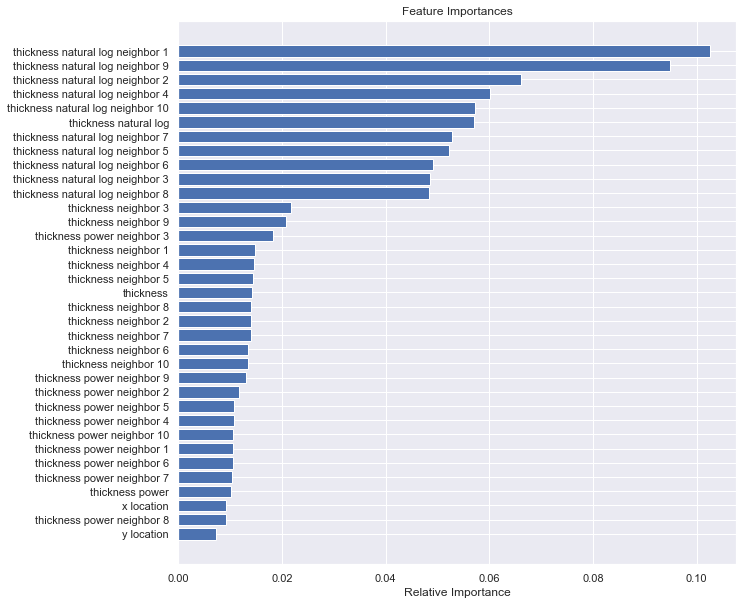

In [22]:
plt.figure(figsize=(10,10))
importances = CLF.feature_importances_
features = subset.columns[:-1].values
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')


In [23]:
plt.hist(subset[subset['class']=='onlap']['thickness natural log'])
plt.hist(subset[subset['class']=='truncation']['thickness natural log'], alpha=0.5)


KeyError: 'class'

In [24]:
# Dataset at https://osf.io/a6cwh/
TOPS_API = pd.read_csv(
    r"subsurface_data.csv"
).fillna(
    0
)  
ITERABLE = ["Kfh", "Kl", "Tfu"]
TOPCOMBOS = list(zip(ITERABLE, ITERABLE[1:]))

RESULTS = []
NORM_ALL = []
PROBS_ALL = []
FULL_PROBS = []

for j in enumerate(TOPCOMBOS):
    print(TOPCOMBOS[j[0]])
    fmtops = list(TOPCOMBOS[j[0]])
    fmtops.extend(["x", "y"])
    tops = TOPS_API[fmtops]
    hoods = adjacent_wells(tops, wells_in_vicinity)
    thicknesses, locations = depth_to_thickness(hoods, tops)
    ft_eng = build_feature_engineered_dataset(thicknesses, locations)
    normalized = data_normalization(ft_eng)
    normalized.columns = FLAT_FEATURES[:-1]
    well_preds = CLF.predict(normalized.values)
    well_prob = CLF.predict_proba(normalized.values)  
    FULL_PROBS.append(well_prob)
    probs = []
    for i in range(len(well_prob)):
        probs.append(well_prob[i].max())
    PROBS_ALL.append(probs)
    RESULTS.append(well_preds)
    NORM_ALL.append(normalized)

('Kfh', 'Kl')


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\strata\lib\site-packages\sklearn\preprocessing\_function_transformer.py:171: RuntimeWarning: divide by zero encountered in log
  return func(X, **(kw_args if kw_args else {}))


normalizing
('Kl', 'Tfu')
normalizing


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\strata\lib\site-packages\sklearn\preprocessing\_function_transformer.py:171: RuntimeWarning: divide by zero encountered in log
  return func(X, **(kw_args if kw_args else {}))


In [28]:
NORMALIZED_KL = NORM_ALL[0]
NORMALIZED_TFU = NORM_ALL[1]

NORMALIZED_KL.columns = subset.columns[0:-1].values
NORMALIZED_KL["class"] = RESULTS[0]
NORMALIZED_KL["prob"] = PROBS_ALL[0]

NORMALIZED_TFU.columns = subset.columns[0:-1].values
NORMALIZED_TFU["class"] = RESULTS[1]
NORMALIZED_TFU["prob"] = PROBS_ALL[1]

NORMALIZED_KL["Formation"] = "Kl"  # this is lance
NORMALIZED_TFU["Formation"] = "Tfu"  # this is ft union

DF_COMBINED = NORMALIZED_KL
DF_COMBINED1 = DF_COMBINED.append(NORMALIZED_TFU, sort=False)

## Now let's project the predictions down to 2D with T-SNE

In [29]:
DF_SUBSET1 = DF_COMBINED1.drop(["class", "Formation", "prob"], axis=1)
tsne = TSNE(
    n_components=2,
    verbose=0.2,
    perplexity=50,
    n_iter=1500,
    learning_rate=500,
    random_state=20,
)  
TSNE_RESULTS = tsne.fit_transform(DF_SUBSET1)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1776 samples in 0.015s...
[t-SNE] Computed neighbors for 1776 samples in 0.202s...
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.687294
[t-SNE] KL divergence after 1500 iterations: 0.843768


In [30]:
PROBABILITIES = np.vstack(FULL_PROBS)

DF_COMBINED1["horiz_prob"] = PROBABILITIES[:, 0]
DF_COMBINED1["onlap_prob"] = PROBABILITIES[:, 1]
DF_COMBINED1["trunc_prob"] = PROBABILITIES[:, 2]

Text(0, 0.5, 't-SNE Dimension 2')

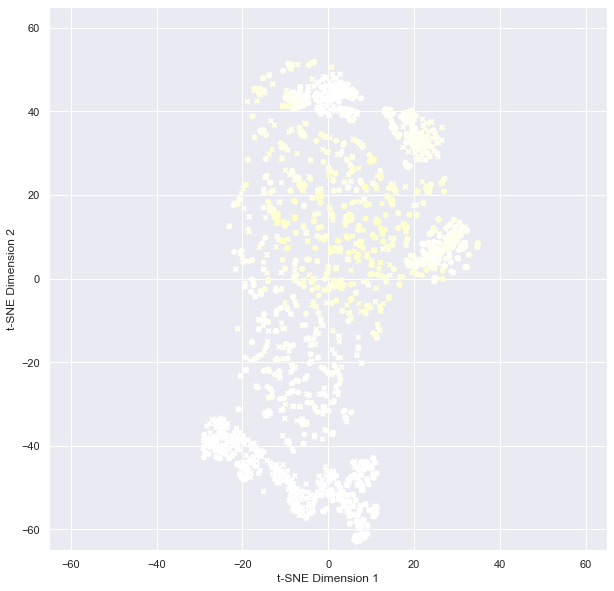

In [31]:
DF_COMBINED1["tsne-2d-one"] = TSNE_RESULTS[:, 0]
DF_COMBINED1["tsne-2d-two"] = TSNE_RESULTS[:, 1]
color_pals = ["#ffffbf", "#2c7bb6", "#d7191c"]

# 0 is truncation, 1 is onlap, 2 is horizontal

plt.figure(figsize=(10, 10))
sns.scatterplot(
    x=DF_COMBINED1["tsne-2d-one"],
    y=DF_COMBINED1["tsne-2d-two"],
    hue=DF_COMBINED1["trunc_prob"],
    style=DF_COMBINED1["Formation"],
    palette=truncCmap,
    data=DF_COMBINED1,
    legend=None,
    alpha=1,
    edgecolor="none",
    vmin=-1,
    vmax=1,
)
plt.xlim(-65, 65)
plt.ylim(-65, 65)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
# plt.savefig('tsne_trunc.pdf')

(-65.0, 65.0)

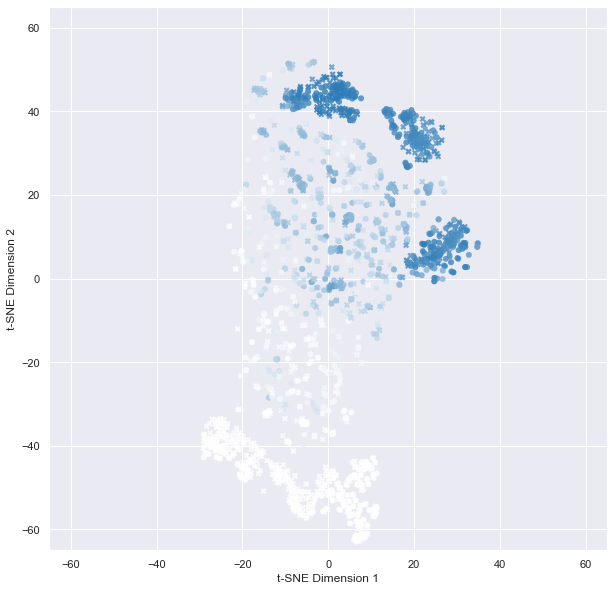

In [32]:
plt.figure(figsize=(10, 10))

sns.scatterplot(
    x=DF_COMBINED1["tsne-2d-one"],
    y=DF_COMBINED1["tsne-2d-two"],
    hue=DF_COMBINED1["onlap_prob"],
    style=DF_COMBINED1["Formation"],
    palette=onlapCmap,
    data=DF_COMBINED1,
    legend=None,
    alpha=0.8,
    edgecolor="none",
)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.xlim(-65, 65)
plt.ylim(-65, 65)
# plt.savefig('tsne_onlap.pdf')

(-65.0, 65.0)

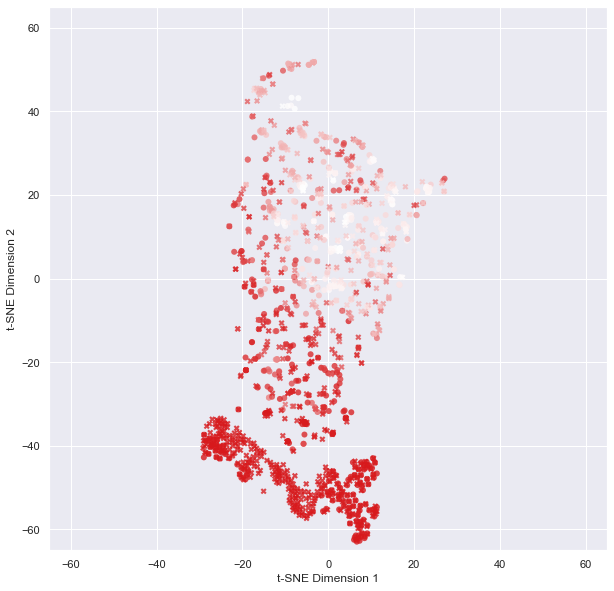

In [33]:
HORIZONTALS = DF_COMBINED1[(DF_COMBINED1.horiz_prob > 0.0)]
plt.figure(figsize=(10, 10))

sns.scatterplot(
    x=HORIZONTALS["tsne-2d-one"],
    y=HORIZONTALS["tsne-2d-two"],
    hue=HORIZONTALS["horiz_prob"],
    style=HORIZONTALS["Formation"],
    palette=horizCmap,
    data=HORIZONTALS,
    legend=None,
    alpha=0.8,
    edgecolor="none",
    vmin=0,
    vmax=1,
)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.xlim(-65, 65)
plt.ylim(-65, 65)
# plt.savefig('tsne_horiz.pdf')

In [34]:
x_locs = TOPS_API.x.append(TOPS_API.x, ignore_index=True)
y_locs = TOPS_API.y.append(TOPS_API.y, ignore_index=True)
API = TOPS_API.API.append(TOPS_API.API, ignore_index=True)

DF_COMBINED1["x_locs"] = x_locs
DF_COMBINED1["y_locs"] = y_locs
DF_COMBINED1["api"] = API

In [35]:
FTUNION = DF_COMBINED1[DF_COMBINED1["Formation"] == "Tfu"]
LANCER = DF_COMBINED1[DF_COMBINED1["Formation"] == "Kl"]

In [36]:
geometry = [Point(xy) for xy in zip(FTUNION.x_locs, FTUNION.y_locs)]
crs = {"init": "epsg:3732"}
geo_df = GeoDataFrame(FTUNION, crs={"init": "epsg:4326"}, geometry=geometry)
geo_df.to_file(
    driver="ESRI Shapefile",
    filename=r"predictions/ftunion_predictions_prob.shp",
 )

geometry = [Point(xy) for xy in zip(LANCER.x_locs, LANCER.y_locs)]
crs = {"init": "epsg:3732"}
geo_df = GeoDataFrame(LANCER, crs={"init": "epsg:4326"}, geometry=geometry)
geo_df.to_file(
    driver="ESRI Shapefile",
    filename=r"predictions/lance_predictions_prob.shp",
 )


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\strata\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [117]:

fig, tax = ternary.figure(scale=1)
fig.set_size_inches(3, 3)

tax.scatter(
    LANCER[["trunc_prob", "onlap_prob", "horiz_prob"]].values,
    marker="o",
    alpha=0.6,
    c="black",
    s=10,
)
tax.scatter(
    FTUNION[["trunc_prob", "onlap_prob", "horiz_prob"]].values,
    marker="x",
    alpha=0.6,
    c="black",
    s=10,
)
tax.left_axis_label("Truncation Probability", fontsize=12, offset=0.08)
tax.right_axis_label("Onlap Probability", fontsize=12, offset=0.08)
tax.bottom_axis_label("Horizontal Probability", fontsize=12, offset=-0.08)
tax.get_axes().axis("off")

tax.boundary(linewidth=1)
tax.gridlines(multiple=0.20, color="gray")
tax.ticks(axis="lbr", linewidth=1, multiple=0.20)
tax.get_axes().axis("off")
# plt.savefig('ternary.pdf')

NameError: name 'ternary' is not defined